from hugginface : https://huggingface.co/learn/cookbook/advanced_rag but applied to our corpus

In [1]:
from tqdm import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.documents import Document

from transformers import AutoTokenizer, Pipeline
from sentence_transformers import SentenceTransformer



In [2]:
#EMBEDDING_MODEL_NAME = "thenlper/gte-small"
EMBEDDING_MODEL_NAME = "thenlper/gte-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-base"

## Building the vector database

In [3]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

In [4]:

#loader = TextLoader("corpus/afrique/au-senegal-une-tiktokeuse-qui-vendait-des-boulettes-pour-faire-grossir-les-fesses-poursuivie.txt")
text_loader_kwargs = {"autodetect_encoding": True}
loader = DirectoryLoader("corpus/", glob='**/**/*.txt', loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
docs = loader.load()

In [5]:
docs_processed = []
for doc in docs:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


100%|██████████| 116/116 [00:00<00:00, 1855.30it/s]


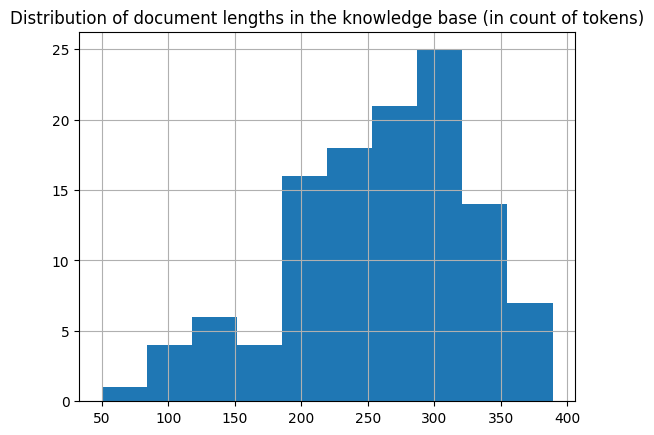

In [6]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
model_max_length = SentenceTransformer('thenlper/gte-small').max_seq_length
print(f"Model's maximum sequence length: {model_max_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [7]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[Document],
    tokenizer,
) -> List[Document]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    model_max_length,
    docs,
    tokenizer,
)

100%|██████████| 82/82 [00:00<00:00, 1509.23it/s]


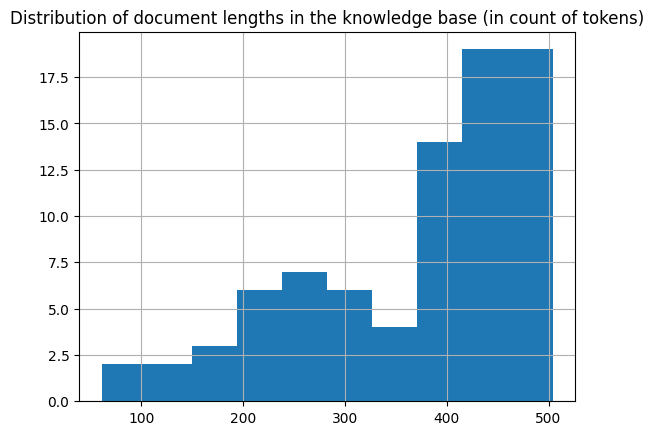

In [8]:

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [9]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

vector_database = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_20612\3932242158.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [10]:
user_query = "Trump"
query_vector = embedding_model.embed_query(user_query)

In [11]:
import pacmap
import numpy as np
import plotly.express as px


embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(vector_database.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [12]:
docs_processed

[Document(metadata={'source': 'corpus\\afrique\\au-niger-des-assises-nationales-censees-fixer-la-duree-de-la-transition.txt', 'start_index': 0}, page_content='Au Niger, des Â«Â\xa0assises nationalesÂ\xa0Â» censÃ©es fixer la durÃ©e de la transition\nLe rÃ©gime militaire au pouvoir au Niger va organiser du 15 au 19Â\xa0fÃ©vrier des Â«Â\xa0assises nationalesÂ\xa0Â», censÃ©es notamment fixer la durÃ©e de la transition ouverte aprÃ¨s le renversement du prÃ©sident civil Mohamed Bazoum enÂ\xa02023. La date des assises a Ã©tÃ© fixÃ©e par le ministÃ¨re de lâ€™intÃ©rieur, dans un communiquÃ© lu Ã\xa0 la tÃ©lÃ©vision dâ€™Etat dans la nuit de samediÂ\xa08Â\xa0Ã\xa0 dimanche 9Â\xa0fÃ©vrier, qui prÃ©cise quâ€™elles se tiendront Ã\xa0 Niamey.\nEn aoÃ»tÂ\xa02023, peu aprÃ¨s sa prise de pouvoir par un putsch, le gÃ©nÃ©ral AbdourahamaneÂ\xa0Tiani avait annoncÃ© lâ€™organisation dâ€™un Â«Â\xa0dialogue national inclusifÂ\xa0Â» qui devait tracer les Â«Â\xa0axes prioritairesÂ\xa0Â» de gouvernance et fixer l

In [13]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            #"source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    #color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [14]:
user_query = "boulette faire grossir fesses afrique"
query_vector = embedding_model.embed_query(user_query)

In [15]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = vector_database.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='boulette faire grossir fesses afrique'...

==================================Top document==================================
Implacable et tentaculaire, le systÃ¨me mis en place par Poutine repose sur deux piliers, les hydrocarbures et le petit groupe de ses fidÃ¨les Ã  qui il a confiÃ© le contrÃ´le des flux financiers. DÃ¨s les premiÃ¨res heures de lâ€™invasion de lâ€™Ukraine, le 24Â fÃ©vrierÂ 2022, il les a convoquÃ©s pour un petit coup de semonce. Assurant nâ€™avoir rien Ã  reprocher Ã  Â«Â ceux qui aiment les huÃ®tres et le foie grasÂ Â», il les a sommÃ©s de se comporter en Â«Â patriotesÂ Â», de rapatrier leurs avoirs, de participer Ã  lâ€™effort de guerre. Le ton Ã©tait menaÃ§antÂ : Â«Â Tous ceux qui nous feront dÃ©faut seront punis.Â Â» RÃ©unis dans la salle Sainte-Catherine du Kremlin, les nouveaux Â«Â boyardsÂ Â» ont fait corps avec le chef.
Le plus fidÃ¨le dâ€™entre eux, Igor Setchine, est un ancien du renseignement militaire soviÃ©tique. Pla

In [16]:
retrieved_docs

[Document(id='ddc58d4d-451c-41f7-834c-ee012aa8ff48', metadata={'source': 'corpus\\culture\\oligarques-le-gang-de-poutine-sur-arte-le-grand-retour-des-boyards-hommes-forts-du-president-russe.txt', 'start_index': 3225}, page_content='Implacable et tentaculaire, le systÃ¨me mis en place par Poutine repose sur deux piliers, les hydrocarbures et le petit groupe de ses fidÃ¨les Ã\xa0 qui il a confiÃ© le contrÃ´le des flux financiers. DÃ¨s les premiÃ¨res heures de lâ€™invasion de lâ€™Ukraine, le 24Â\xa0fÃ©vrierÂ\xa02022, il les a convoquÃ©s pour un petit coup de semonce. Assurant nâ€™avoir rien Ã\xa0 reprocher Ã\xa0 Â«Â\xa0ceux qui aiment les huÃ®tres et le foie grasÂ\xa0Â», il les a sommÃ©s de se comporter en Â«Â\xa0patriotesÂ\xa0Â», de rapatrier leurs avoirs, de participer Ã\xa0 lâ€™effort de guerre. Le ton Ã©tait menaÃ§antÂ\xa0: Â«Â\xa0Tous ceux qui nous feront dÃ©faut seront punis.Â\xa0Â» RÃ©unis dans la salle Sainte-Catherine du Kremlin, les nouveaux Â«Â\xa0boyardsÂ\xa0Â» ont fait corps 

# DeepSeek

In [17]:
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

In [18]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [19]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [20]:
llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.1,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=2000,
)

Device set to use cuda:0


In [21]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """
You are a news reporter summerizing news for the last 24 hours. 
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from the selected documents. 

Context:
{context}

""",
    },
    {
        "role": "user",
        "content": """
---
Now, here are the subjects from which you should build your news reports.

subject: What are the most important news reguarding {subject} ? """,
    },
]

rag_prompt_template = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(rag_prompt_template)

<｜begin▁of▁sentence｜>
You are a news reporter summerizing news for the last 24 hours. 
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from the selected documents. 

Context:
{context}

<｜User｜>
---
Now, here are the subjects from which you should build your news reports.

subject: What are the most important news reguarding {subject} ? <｜Assistant｜><think>



In [22]:
# question = "France"
# user_query = question
# retrieved_docs = vector_database.similarity_search_with_score(query=user_query, k=10)

In [23]:
#retrieved_docs

In [24]:
# retrieved_docs_text = [doc[0].page_content for doc in retrieved_docs]  # We only need the text of the documents
# context = "\nDocuments :\n"
# context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

# final_prompt = rag_prompt_template.format(context=context, subject=question)

# # Redact an answer
# llm_answer = llm(final_prompt)

In [25]:
# answer = llm_answer[0]["generated_text"]
# print(answer)

In [26]:
from ragatouille import RAGPretrainedModel

reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

f:\Projects\Repos\RT_News_Summarizer\.venv\Lib\site-packages\colbert\utils\amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



In [49]:

def answer_with_rag(
            question: str,
            llm: Pipeline,
            knowledge_index: FAISS,
            reranker: Optional[RAGPretrainedModel] = None,
            num_retrieved_docs: int = 30,
            num_docs_final: int = 5,
        ) -> Tuple[str, List[Document]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    relevant_docs_text = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs_text = reranker.rerank(question, relevant_docs_text, k=num_docs_final)
        relevant_docs_text = [doc["content"] for doc in relevant_docs_text]

    relevant_docs_text = relevant_docs_text[:num_docs_final]

    #relevant_docs_text = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs_text)])

    final_prompt = rag_prompt_template.format(subject=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs_text

In [50]:
question = "Trump"

#answer, relevant_docs = answer_with_rag(question, llm, vector_database, reranker=None, num_retrieved_docs=30, num_docs_final=7)
answer, relevant_docs = answer_with_rag(question, llm, vector_database, reranker=reranker, num_retrieved_docs=30, num_docs_final=7)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

=> Generating answer...


In [51]:
relevant_docs

['Lâ€™extrÃªme droite europÃ©enne Ã\xa0 lâ€™ombre de Trump\nLe premier ministre hongrois, Viktor Orban, avait placÃ© la prÃ©sidence tournante de lâ€™Union europÃ©enne, que son pays occupait au second semestre 2024, sous le signe MEGA, Make Europe great again (Â«Â\xa0rendre sa grandeur Ã\xa0 lâ€™EuropeÂ\xa0Â»), comme un dÃ©fi lancÃ© Ã\xa0 lâ€™Europe quâ€™il abhorre. Le retour tonitruant Ã\xa0 la Maison Blanche de Donald Trump, pÃ¨re du slogan MAGA, Make America great again, et phare des extrÃªmes droites europÃ©ennes, imposait donc que le sommet de Patriotes pour lâ€™Europe, troisiÃ¨me groupe au Parlement europÃ©en, samedi 8Â\xa0fÃ©vrier, Ã\xa0 Madrid, fasse sien, Ã\xa0 son tour, le cri de ralliement MEGA.',
 'Donald Trump veut mettre fin au penny\nLes Etats-Unis vont-ils en finir avec le pennyÂ\xa0? Le prÃ©sident amÃ©ricain, Donald Trump, aÂ\xa0ordonnÃ©, dimanche 9Â\xa0fÃ©vrier, Ã\xa0 son secrÃ©taire au TrÃ©sor, Scott Bessent, dâ€™arrÃªter la production de cette piÃ¨ce valant un centiÃ

In [52]:
print(answer)

Okay, I need to help the user by creating a detailed news report based on their provided context and documents. The user has given me several documents, each discussing different aspects of Trump's policies and his relation to the European Union. They also provided six other documents covering various topics like economic policies, political strategies, etc. My task is to summarize the key points from these documents as per the user's instructions.

First, I'll read through all the documents carefully to identify the main themes and any overlaps or differences. Document 0 talks about Trump's role in the EU's "make America great again" campaign, mentioning his support for MEGA and the return of the EU presidency. Document 1 discusses Trump's response to the penny issue, specifically how he tried to reduce expenses but faced resistance. Document 2 focuses on Trump's performance during the match without the audience, highlighting his lack of support. Document 3 delves into the internal dy